In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentence/36979.txt
/kaggle/input/images/images/2715746315.jpg
/kaggle/input/images/images/3463034205.jpg
/kaggle/input/images/images/268704620.jpg
/kaggle/input/images/images/2673564214.jpg
/kaggle/input/images/images/7535037918.jpg
/kaggle/input/images/images/4912369161.jpg
/kaggle/input/images/images/4828071602.jpg
/kaggle/input/images/images/6802728196.jpg
/kaggle/input/images/images/3346289227.jpg
/kaggle/input/images/images/3217056901.jpg
/kaggle/input/images/images/272471327.jpg
/kaggle/input/images/images/4717261252.jpg
/kaggle/input/images/images/4763916790.jpg
/kaggle/input/images/images/2700788458.jpg
/kaggle/input/images/images/2795287622.jpg
/kaggle/input/images/images/4453893059.jpg
/kaggle/input/images/images/2094323311.jpg
/kaggle/input/images/images/2375770917.jpg
/kaggle/input/images/images/5962278982.jpg
/kaggle/input/images/images/2460568004.jpg
/kaggle/input/images/images/2567962271.jpg
/kaggle/input/images/images/4569787426.jpg
/kaggle/input/images/im

In [41]:
# Cell 1: Setup, Install, and Imports
!pip install torch torchvision transformers scikit-learn tqdm

import os
import numpy as np
import pandas as pd
import torch
import torchvision
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertModel
from torchvision.transforms.functional import to_tensor
from torchvision.ops import roi_align


In [42]:
# Cell 2: Paths and Device
sentences_dir = '/kaggle/input/sentences/Sentences'
annotations_dir = '/kaggle/input/annotations/Annotations'
images_dir = '/kaggle/input/images/images'
save_dir = './cached_feats'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [43]:
# Cell 3: Read PASCAL VOC XML Annotations
import xml.etree.ElementTree as ET

def read_pascal_voc_order(xml_path):
    boxes = []
    labels = []
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(obj.find("name").text)
    return boxes, labels


In [44]:
# Cell 4: Prepare query-region pairs (sentence to box)
def prepare_query_region_pairs_order_skip_unmatched(sentences_dir, annotations_dir):
    dataset = []
    for fname in os.listdir(sentences_dir):
        if fname.endswith('.txt'):
            image_id = fname.replace('.txt', '')
            xml_path = os.path.join(annotations_dir, f"{image_id}.xml")
            sentence_path = os.path.join(sentences_dir, fname)
            if not os.path.exists(xml_path):
                continue
            boxes, labels = read_pascal_voc_order(xml_path)
            with open(sentence_path, 'r', encoding='utf-8') as f:
                sentences = [line.strip() for line in f if line.strip()]
            for idx, sentence in enumerate(sentences):
                if idx < len(boxes):
                    dataset.append({
                        'image_id': image_id,
                        'sentence': sentence,
                        'target_box_idx': idx,
                        'box': boxes[idx],
                        'label': 1
                    })
                    for neg_idx in range(len(boxes)):
                        if neg_idx != idx:
                            dataset.append({
                                'image_id': image_id,
                                'sentence': sentence,
                                'target_box_idx': neg_idx,
                                'box': boxes[neg_idx],
                                'label': 0
                            })
    return dataset


In [45]:
# Cell 5: Feature extractors (Faster R-CNN and BERT)
fasterrcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT").to(device)
fasterrcnn_model.eval()
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

def extract_fasterrcnn_features(image_path, boxes):
    image = Image.open(image_path).convert("RGB")
    image_tensor = to_tensor(image).to(device)
    with torch.no_grad():
        backbone_features = fasterrcnn_model.backbone(image_tensor.unsqueeze(0))
    feat = backbone_features['0']
    if len(boxes) == 0:
        return torch.empty(0)
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32).to(device)
    batch_indices = torch.zeros(len(boxes_tensor), 1).to(device)
    roi_boxes = torch.cat([batch_indices, boxes_tensor], dim=1)
    pooled_features = roi_align(feat, roi_boxes, output_size=(7, 7), spatial_scale=1/4.0)
    return pooled_features.cpu()

@torch.no_grad()
def encode_sentences(sentences, max_length=128):
    encoded_inputs = bert_tokenizer(sentences, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings.cpu()


In [46]:
# Cell 6: Dataset/Loader classes
class VisualGroundingDataset(torch.utils.data.Dataset):
    def __init__(self, data, feature_extractor, text_encoder, images_dir):
        self.data = data
        self.feature_extractor = feature_extractor
        self.text_encoder = text_encoder
        self.images_dir = images_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.images_dir, f"{item['image_id']}.jpg")
        boxes = [item['box']]
        visual_feats = self.feature_extractor(image_path, boxes)
        sentence_embedding = self.text_encoder([item['sentence']])
        return {
            'visual_feats': visual_feats.squeeze(0),
            'sentence_embeddings': sentence_embedding.squeeze(0),
            'label': torch.tensor(item['label'], dtype=torch.float32)
        }

def collate_fn(batch):
    visual_feats = torch.stack([b['visual_feats'] for b in batch])
    sentence_embeddings = torch.stack([b['sentence_embeddings'] for b in batch])
    labels = torch.stack([b['label'] for b in batch])
    return visual_feats, sentence_embeddings, labels


In [47]:
# Add as a new cell (replace old precompute_and_save_features Cell 7)

from tqdm import tqdm
import torch
from PIL import Image
from torchvision.transforms.functional import to_tensor
from torchvision.ops import roi_align

def batch_fasterrcnn_features(image_paths, boxes_list):
    images = [to_tensor(Image.open(p).convert("RGB")).to(device) for p in image_paths]
    visual_feats = []
    fasterrcnn_model.eval()
    with torch.no_grad():
        for i, image_tensor in enumerate(images):
            boxes = boxes_list[i]
            if len(boxes) == 0:
                visual_feats.append(torch.empty(0))
                continue
            backbone_feat = fasterrcnn_model.backbone(image_tensor.unsqueeze(0))['0']
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32).to(device)
            batch_indices = torch.zeros(len(boxes_tensor), 1).to(device)
            roi_boxes = torch.cat([batch_indices, boxes_tensor], dim=1)
            pooled_feats = roi_align(backbone_feat, roi_boxes, output_size=(7,7), spatial_scale=1/4.0)
            visual_feats.append(pooled_feats.cpu().squeeze(0))
    return visual_feats

@torch.no_grad()
def batch_encode_sentences(sentences, max_length=128):
    encoded_inputs = bert_tokenizer(sentences, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    bert_model.eval()
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    return outputs.last_hidden_state[:, 0, :].cpu()

def kaggle_cache_features(dataset, images_dir, save_dir, batch_size=8):
    import os
    os.makedirs(save_dir, exist_ok=True)
    for start in tqdm(range(0, len(dataset), batch_size), desc="Caching features"):
        batch = dataset[start:start+batch_size]
        image_paths = [os.path.join(images_dir, f"{item['image_id']}.jpg") for item in batch]
        boxes_list = [[item['box']] for item in batch]
        sentences = [item['sentence'] for item in batch]
        visual_feats = batch_fasterrcnn_features(image_paths, boxes_list)
        text_feats = batch_encode_sentences(sentences)
        for i, item in enumerate(batch):
            sample = {
                "visual_feats": visual_feats[i],
                "sentence_embeddings": text_feats[i],
                "label": torch.tensor(float(item['label']), dtype=torch.float32)
            }
            torch.save(sample, os.path.join(save_dir, f"{start+i}.pt"))


In [49]:
# Add this cell before preparing your dataset (place before Cell 8)

def read_pascal_voc_order(xml_path):
    import xml.etree.ElementTree as ET
    boxes = []
    labels = []
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        # Robust skip: if bbox or any coordinate is missing
        if bbox is None or bbox.find("xmin") is None or bbox.find("ymin") is None \
                or bbox.find("xmax") is None or bbox.find("ymax") is None:
            continue
        try:
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))
        except Exception:
            continue  # skip object if coordinate is unreadable
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(obj.find("name").text)
    return boxes, labels


In [50]:
import random
import numpy as np
import os
import torch
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

class CachedFeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, indices, save_dir):
        self.indices = indices
        self.save_dir = save_dir

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = torch.load(os.path.join(self.save_dir, f"{self.indices[idx]}.pt"))
        return sample

# Prepare full dataset
dataset_all = prepare_query_region_pairs_order_skip_unmatched(sentences_dir, annotations_dir)
# Extract labels for stratified sampling
labels = np.array([item['label'] for item in dataset_all])
# Stratified 10% subsample (~3000 samples) for faster processing
splitter = StratifiedShuffleSplit(n_splits=1, train_size=0.1, random_state=42)
indices = np.arange(len(dataset_all))
for subset_idx, _ in splitter.split(indices, labels):
    subset_indices = subset_idx
# Subset dataset for caching and training
new_dataset_all = [dataset_all[i] for i in subset_indices]
save_dir = './cached_feats'
if not os.path.exists(save_dir) or len(os.listdir(save_dir)) < len(new_dataset_all):
    kaggle_cache_features(new_dataset_all, images_dir, save_dir, batch_size=16)  # Your batch caching function from previous cell
indices = list(range(len(new_dataset_all)))
labels = np.array([item['label'] for item in new_dataset_all])
train_idx, test_idx = train_test_split(indices, test_size=0.4, random_state=42, stratify=labels)
positives = [idx for idx in train_idx if new_dataset_all[idx]['label'] == 1]
negatives = [idx for idx in train_idx if new_dataset_all[idx]['label'] == 0]
random.seed(42)
if len(positives) < len(negatives):
    extras = len(negatives) - len(positives)
    oversampled_positives = positives + random.choices(positives, k=extras)
else:
    oversampled_positives = positives
balanced_train_idx = oversampled_positives + negatives
random.shuffle(balanced_train_idx)
train_dataset = CachedFeaturesDataset(balanced_train_idx, save_dir)
test_dataset = CachedFeaturesDataset(test_idx, save_dir)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


In [51]:
# Cell 9: Model definition
import torch.nn as nn

class SimpleMultimodalGroundingModel(nn.Module):
    def __init__(self, visual_feat_dim=256*7*7, text_embed_dim=768, hidden_dim=512, num_classes=1):
        super(SimpleMultimodalGroundingModel, self).__init__()
        self.visual_fc = nn.Linear(visual_feat_dim, hidden_dim)
        self.text_fc = nn.Linear(text_embed_dim, hidden_dim)
        self.fusion_fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.output_fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, visual_feats, text_embeds):
        batch_size = visual_feats.size(0)
        visual_feats = visual_feats.view(batch_size, -1)
        visual_proj = torch.relu(self.visual_fc(visual_feats))
        text_proj = torch.relu(self.text_fc(text_embeds))
        fusion_input = torch.cat((visual_proj, text_proj), dim=1)
        fused = torch.relu(self.fusion_fc(fusion_input))
        fused = self.dropout(fused)
        out = self.output_fc(fused)
        return out.squeeze(1)
model = SimpleMultimodalGroundingModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
n_pos = sum(1 for idx in balanced_train_idx if dataset_all[idx]['label'] == 1)
n_neg = sum(1 for idx in balanced_train_idx if dataset_all[idx]['label'] == 0)
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [52]:
# Cell 10: Training and evaluation functions
def train_one_epoch(dataloader, model, optimizer):
    model.train()
    total_loss = 0
    for visual_feats, sentence_embeds, labels in dataloader:
        visual_feats, sentence_embeds, labels = visual_feats.to(device), sentence_embeds.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(visual_feats, sentence_embeds)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * visual_feats.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(dataloader, model, threshold=0.5):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for visual_feats, sentence_embeds, labels in dataloader:
            visual_feats, sentence_embeds, labels = visual_feats.to(device), sentence_embeds.to(device), labels.to(device)
            outputs = model(visual_feats, sentence_embeds)
            preds = (torch.sigmoid(outputs) > threshold)
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [53]:
num_epochs = 10  # Reduced for faster training

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_dataloader, model, optimizer)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}")

print("Training complete.")

test_acc = evaluate(test_dataloader, model, threshold=0.5)
print(f"Test Accuracy @ threshold 0.5: {test_acc:.4f}")

model.eval()
all_labels = []
all_probs = []
with torch.no_grad():
    for visual_feats, sentence_embeds, labels in test_dataloader:
        visual_feats, sentence_embeds = visual_feats.to(device), sentence_embeds.to(device)
        outputs = model(visual_feats, sentence_embeds)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

thresholds = np.arange(0.05, 1.0, 0.05)
best_thresh, best_f1 = 0.5, 0.0

for thresh in thresholds:
    preds = (all_probs > thresh).astype(int)
    f1 = f1_score(all_labels, preds, zero_division=0)
    precision = precision_score(all_labels, preds, zero_division=0)
    recall = recall_score(all_labels, preds, zero_division=0)
    print(f"Threshold: {thresh:.2f} | F1: {f1:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

final_preds = (all_probs > best_thresh).astype(int)
print("Best Threshold:", best_thresh)
print("Confusion Matrix:\n", confusion_matrix(all_labels, final_preds))
print("Precision:", precision_score(all_labels, final_preds, zero_division=0))
print("Recall:", recall_score(all_labels, final_preds, zero_division=0))
print("F1-score:", f1_score(all_labels, final_preds, zero_division=0))


Epoch 1 | Train Loss: 1.4837
Epoch 2 | Train Loss: 1.3616
Epoch 3 | Train Loss: 1.1877
Epoch 4 | Train Loss: 0.9779
Epoch 5 | Train Loss: 0.7717
Epoch 6 | Train Loss: 0.5935
Epoch 7 | Train Loss: 0.4514
Epoch 8 | Train Loss: 0.3504
Epoch 9 | Train Loss: 0.2804
Epoch 10 | Train Loss: 0.2362
Training complete.
Test Accuracy @ threshold 0.5: 0.7832
Threshold: 0.05 | F1: 0.230 | Precision: 0.151 | Recall: 0.482
Threshold: 0.10 | F1: 0.225 | Precision: 0.154 | Recall: 0.415
Threshold: 0.15 | F1: 0.217 | Precision: 0.154 | Recall: 0.367
Threshold: 0.20 | F1: 0.212 | Precision: 0.155 | Recall: 0.335
Threshold: 0.25 | F1: 0.206 | Precision: 0.155 | Recall: 0.307
Threshold: 0.30 | F1: 0.200 | Precision: 0.155 | Recall: 0.283
Threshold: 0.35 | F1: 0.195 | Precision: 0.155 | Recall: 0.262
Threshold: 0.40 | F1: 0.190 | Precision: 0.155 | Recall: 0.244
Threshold: 0.45 | F1: 0.183 | Precision: 0.154 | Recall: 0.226
Threshold: 0.50 | F1: 0.174 | Precision: 0.151 | Recall: 0.206
Threshold: 0.55 | F1: 

Best box: [148  22 500 368]


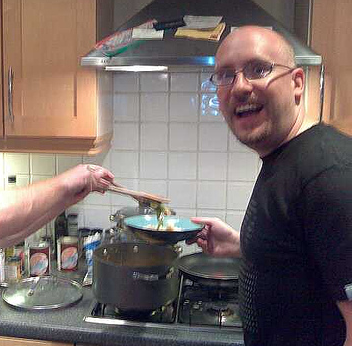

In [67]:
from PIL import Image
from torchvision.transforms import ToTensor
from IPython.display import display

def localize_and_crop(query_text, image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = ToTensor()(image).to(device)
    with torch.no_grad():
        outputs = fasterrcnn_model([image_tensor])
    boxes = outputs[0]['boxes'].cpu().numpy().astype(int)
    query_emb = encode_sentences([query_text]).to(device)
    best_score = -float('inf')
    best_box = None
    for box in boxes:
        visual_feat = extract_fasterrcnn_features(image_path, [box]).to(device).squeeze(0).unsqueeze(0)
        out = model(visual_feat, query_emb)
        score = torch.sigmoid(out).item()
        if score > best_score:
            best_score, best_box = score, box
    crop = image.crop(tuple(best_box)) if best_box is not None else image
    print("Best box:", best_box)
    display(crop)
    return crop

# Example call:
result = localize_and_crop(
    "[/EN#30/people Two men] , [/EN#31/other one] in [/EN#32/clothing a gray shirt] , [/EN#33/other one] in [/EN#34/clothing a black shirt] , standing near [/EN#35/other a stove] .[/EN#30/people Two guy] cooking and joking around with [/EN#0/notvisual the camera] .[/EN#30/people Two men] in [/EN#37/scene a kitchen] cooking [/EN#36/other food] on [/EN#35/other a stove] .[/EN#30/people Two men] are at [/EN#35/other the stove] preparing [/EN#36/other food] .[/EN#30/people Two men] are cooking [/EN#36/other a meal] .",
    "/kaggle/input/images/images/1000366164.jpg"
)
#input img nd annotation query above 

Query: [/EN#92421/animals A small white dog] runs across [/EN#92424/other the sand] .
Best box: [ 28 225  57 236]


Query: [/EN#45443/people A little girl] chasing [/EN#45447/animals pigeons] in [/EN#45445/scene a park] .
Best box: [302 116 359 261]


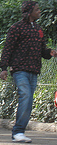

Query: [/EN#249235/other Many two-person kayaks] fill [/EN#249236/scene a river] surrounded by [/EN#249237/other trees] .
Best box: [138 174 159 190]


Query: [/EN#27836/people An older man] , not white , is sitting at [/EN#27837/other a table] attempting to sell [/EN#27838/other different varieties of soda] and [/EN#27839/other cigarettes] , including [/EN#27848/other Pepsi] , [/EN#27840/other orange Fanta] , and [/EN#27841/other Marlboro] .
Best box: [  0 322 354 499]


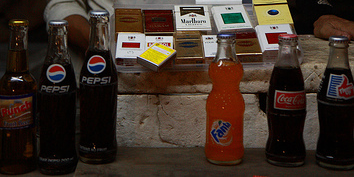

Query: [/EN#214984/people Many people] are outside in [/EN#214989/scene a town] wearing [/EN#214985/clothing safety vests] walking around .
Best box: [  3 301 135 324]


In [56]:
#cell 13
for i in range(5):
    idx = test_idx[i]
    item = new_dataset_all[idx]
    query_text = item["sentence"]
    image_path = os.path.join(images_dir, f"{item['image_id']}.jpg")
    print(f"Query: {query_text}")
    localize_and_crop(query_text, image_path)


In [63]:
pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.
